# Визуализация сложных данных. t-SNE
![](https://d3ansictanv2wj.cloudfront.net/images/animation-94a2c1ff.gif)

In [1]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv')
data = data[data['Status'] > 0] # Status = 0 - шум
data = pd.get_dummies(data, columns=['Home', 'Job', 'Marital']) # One-Hot encoding
X, y = data.drop('Status', 1), data['Status']
print(X.shape, y.shape)
X.head()

(4454, 28) (4454,)


,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price,...,Job_1,Job_2,Job_3,Job_4,Marital_0,Marital_1,Marital_2,Marital_3,Marital_4,Marital_5
0,9,60,30,1,73,129,0,0,800,846,...,0,0,1,0,0,0,1,0,0,0
1,17,60,58,1,48,131,0,0,1000,1658,...,1,0,0,0,0,0,0,1,0,0
2,10,36,46,2,90,200,3000,0,2000,2985,...,0,0,1,0,0,0,1,0,0,0
3,0,60,24,1,63,182,2500,0,900,1325,...,1,0,0,0,0,1,0,0,0,0
4,0,36,26,1,46,107,0,0,310,910,...,1,0,0,0,0,1,0,0,0,0


Такие данные не визуализируешь ... Но есть t-SNE! ОООЧЕНЬ долго работающий на больших данных, но у нас, к счастью, данных не так немного

In [2]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

In [3]:
X_embedded.shape

(4454, 2)

Всё сжалось до 2 признаков

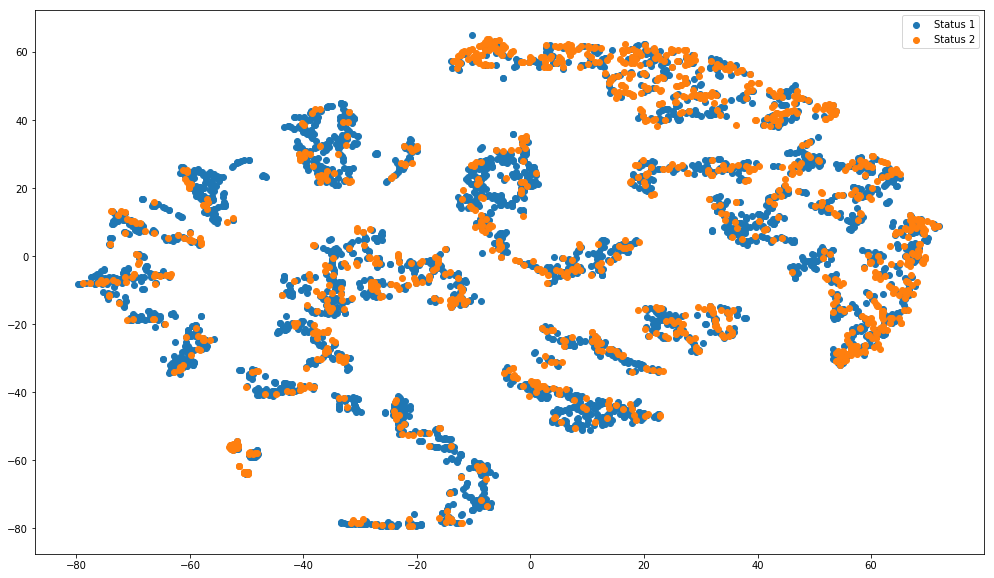

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(17,10))
zeros_idx = np.argwhere(y == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_embedded[zeros_idx, 0], X_embedded[zeros_idx, 1], label='Status 1')
plt.scatter(X_embedded[ones_idx, 0], X_embedded[ones_idx, 1], label='Status 2')
plt.legend()

Обучим теперь какой-нибудь классификатор и визуализируем его предсказания

In [12]:
from sklearn.model_selection import train_test_split
X_emb_train, X_emb_test, X_train, X_test, y_train, y_test = train_test_split(X_embedded, X, y, train_size=0.8)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

c:\users\artem\anaconda3\envs\wos\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


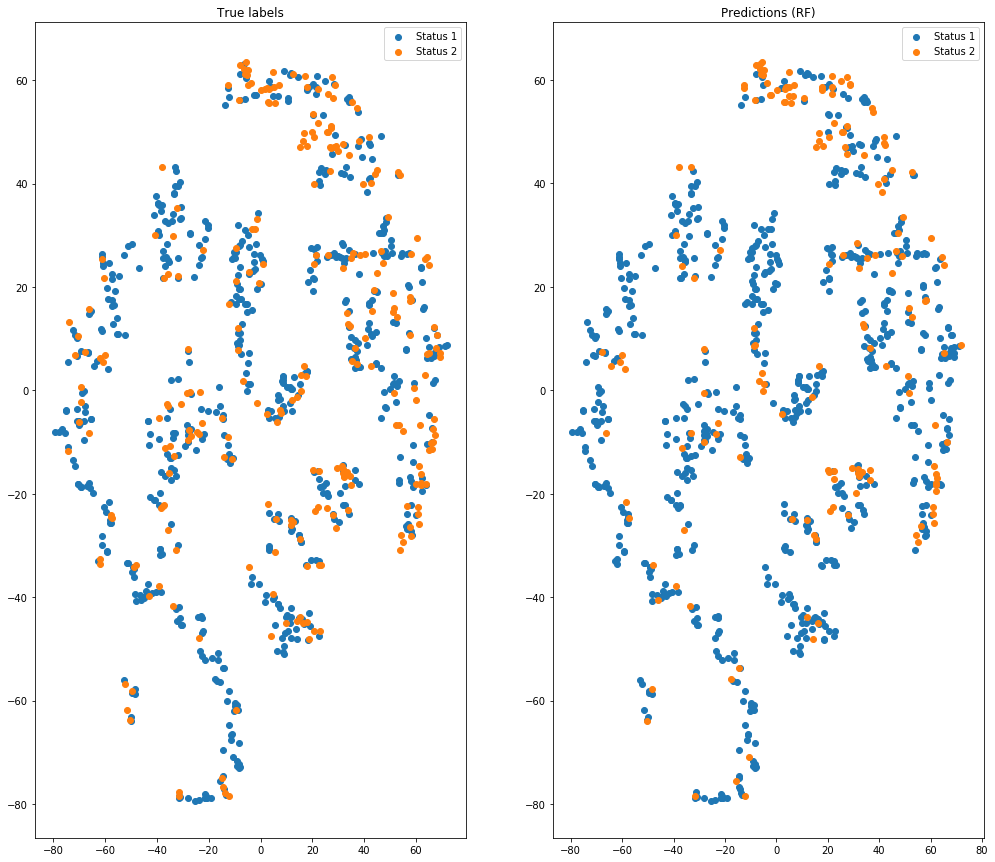

In [15]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (RF)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()


### Резюме

**Плюсы:**
* Позволяет визуализировать высокоразмерные (-признаковые) данные
* Возможность получать представление произвольной размерности, необязательно двумерное (n_components=2)
* Сохраняется гипотеза компактности: похожие (близкие) объекты исходного представления остаются близкими в "схлопнутом" низкомерном представлении
* Наличие оптимизированных и распараллеленных [реализаций](https://github.com/DmitryUlyanov/Multicore-TSNE)

**Минусы:**
* ООЧЕНЬ ДООООЛГИЙ (во всяком случае, нераспараллеленная SkLearn'ая версия). Как правило, достаточно нескольких тысяч объектов в выборке, чтобы t-SNE "присел" минут на 10

# Детектирование аномалий

![](https://alexanderdyakonov.files.wordpress.com/2017/04/outlier_detection2.jpg)

Строго говоря, в анализе данных есть два направления, которые занимаются поиском аномалий: детектирование выбросов (Outlier Detection) и «новизны» (Novelty Detection). Как и выброс «новый объект» — это объект, который отличается по своим свойствам от объектов (обучающей) выборки.  Но  в отличие от выброса, его в самой выборке пока нет (он появится через некоторое время, и задача как раз и заключается в том, чтобы обнаружить его при появлении). Например, если вы анализируете замеры температуры и отбрасываете аномально большие или маленькие, то Вы боретесь с выбросами. А если Вы создаёте алгоритм, который для каждого нового замера оценивает, насколько он похож на прошлые, и выбрасывает аномальные — Вы «боретесь с новизной».

## 1. Статистический тест

Как правило, применяют для отдельных признаков и отлавливают экстремальные значения (Extreme-Value Analysis). Для этого используют, например, Z-value или Kurtosis measure.

![](https://alexanderdyakonov.files.wordpress.com/2017/04/kurtosis2.png)

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[y_train == 1]) # обучим scaler только на хороших данных
X_transform = scaler.transform(X_test) # наши Z-value (это преобразование можно использовать для нормировки данных)

In [153]:
X_transform.shape

(891, 28)

Теперь можно по правилу 3 сигм (можно и любой другой уровень значимости выбрать) выявить объекты-выбросы, Z-value которых выходить за допустимый интервал

In [154]:
outlier_indices = (X_transform < -3).astype(np.uint8).sum(axis=1) + (X_transform > 3).astype(np.uint8).sum(axis=1) > 0 # массив булевых значений. True - если выброс, False
y_test[outlier_indices].mean(), y_test.mean()

(1.4819672131147541, 1.2974186307519642)

Видим, что среди выбросов доля "Status 2" (невозвращенных кредитов) выше 

In [155]:
y_pred = 1 + outlier_indices.astype(np.uint8) # получим предсказания. Т.к. y_pred - 1 или 2, а outlier_indices.astype(np.uint8) - 0 или 1 (1 - выброс, 0 - нет), то добавим 1

from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.6902356902356902

Точность классификации получилась 69%! Это при том, что это обучение без учителя, т.е. мы вообще никак не использовали правильные ответы!

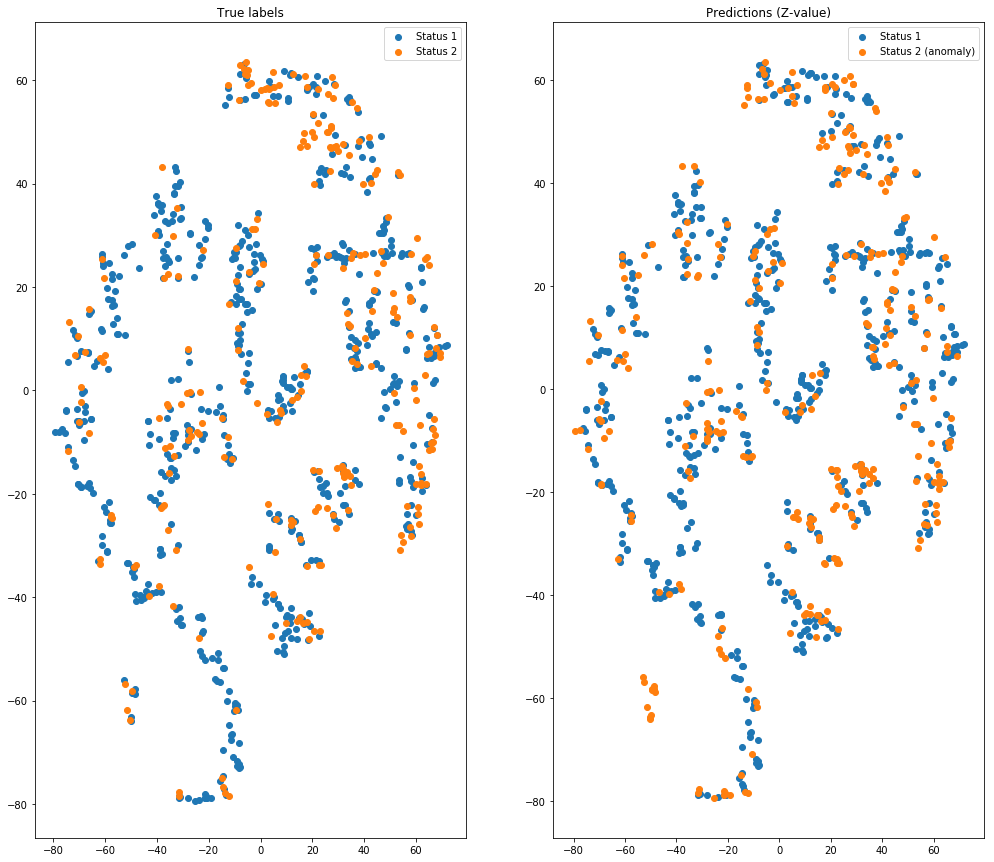

In [156]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Z-value)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2 (anomaly)')
plt.legend()

### Резюме
**Плюсы:**
* Никакого машинного обучения :) Z-value - чисто статистический тест
* Быстрый
* Простой
* Возможность на одних данных обучать, к другим - применять

**Минусы:**
* На сложных данных может не работать

**Специфика применения:** простые выбросы и новизна

## 2 Local outlier factor
[Local outlier factor](https://en.wikipedia.org/wiki/Local_outlier_factor) очень похож на метод ближайших соседей, только без учителя. Вот как он работает:

![](https://alexanderdyakonov.files.wordpress.com/2017/04/fig2_nns.png)

На рис. выше считается расстояние от каждого объекта до ближайшего соседа, определённым образом нормируется и полученная величина тем выше, чем больше вероятность аномалии. Результат получается примерно такой:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/LOF.svg/600px-LOF.svg.png)

In [115]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = 1 + (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 2, а +1 перешла в +1

accuracy_score(y_pred, y_test)

0.65319865319865322

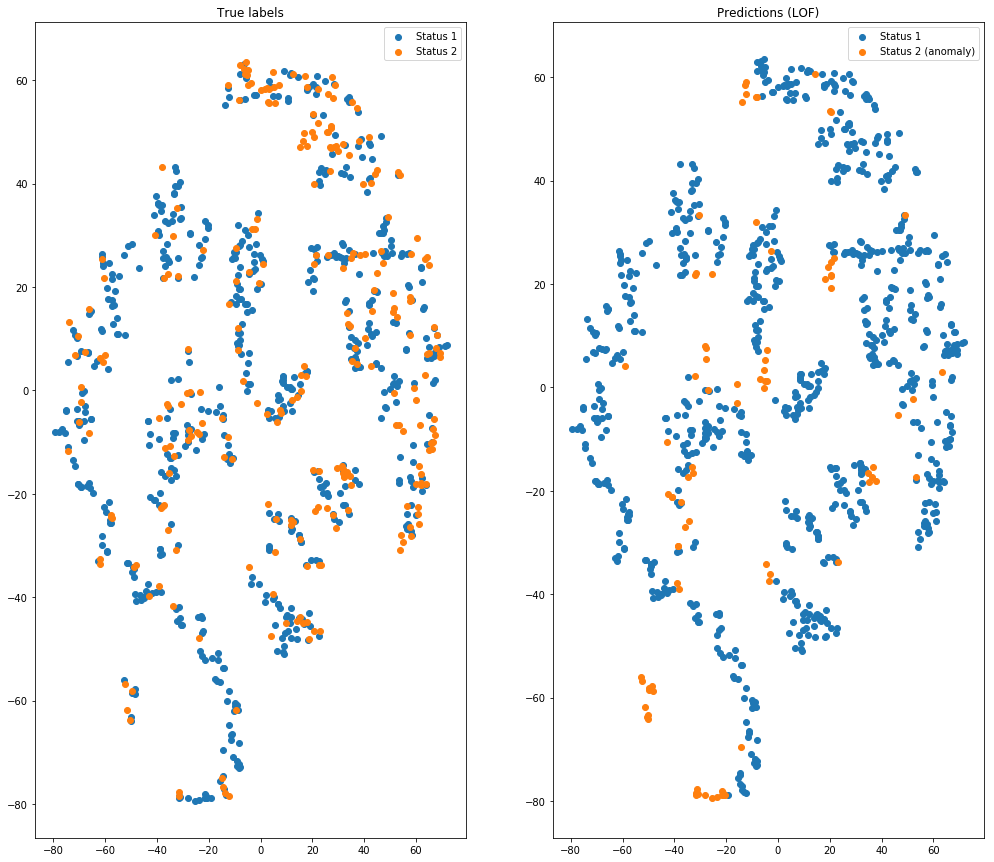

In [112]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (LOF)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2 (anomaly)')
plt.legend()


Видим, как LOF хорошо определил выбросы

### Резюме
**Плюсы:**
* Понятный

**Минусы:**
* Медленный
* Нет возможности обучиться на одних данных, а получить предсказания для других. Есть только метод .fit_predict()


**Специфика применения:** выбросы и новизна

**Что можно улучшить:**
* Погридсёчить параметры

## 3. Методы машинного обучения
![](https://alexanderdyakonov.files.wordpress.com/2017/04/fig_all.png?w=1024)

## 3.1 One-Class SVM
Основная идея - построить такую минимальную оболочку вокруг обучающей выборки, которая полностью бы содержала объекты обучающей выборки

In [136]:
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline

clf = Pipeline([('scaler', StandardScaler()), ('estimator', OneClassSVM())])
clf.fit(X_train[y_train == 1]) # покажем модели, как выглядят хорошие заёмщики
y_pred = clf.predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = 1 + (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 2, а +1 перешла в +1

accuracy_score(y_pred, y_test)

0.60606060606060608

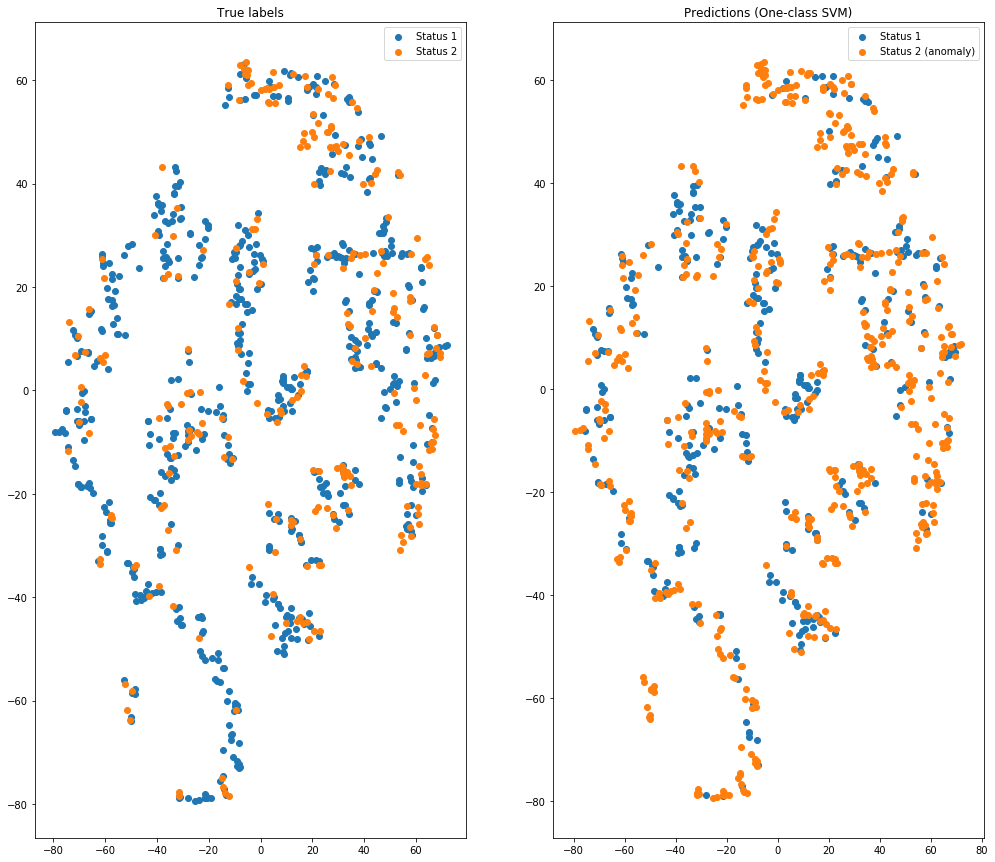

In [138]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (One-class SVM)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2 (anomaly)')
plt.legend()


### Резюме
**Плюсы:**
* Эффективный
* Намного быстрее LOF (KNN)
* Можно обучать на одних данных (например, только хороших), а применять к другим

**Минусы:**
* На очень больших данных работает долго (когда миллионы объектов)
* Плохо выявляет сложные зависимости
* Аномально плохо работает с не RBF-ядрами

**Что можно улучшить:**
* Погридсёчить параметры


**Специфика применения:** только новизна и сильные выбросы

## 3.2 IsolationForest
Идея IsolationForest - определить номер объекта с помощью решающих правил. Казалось бы, что это очень похоже на переобучение, однако такой подход имеет интересные свойства: оказывается, что таким деревьям аномальные объекты и выбросы гораздо легче отделить от выборки с помощью правил, поскольку его сложно спутать с остальными объектами! Это тот случай, когда переобучение идёт нам на руку!

![](https://alexanderdyakonov.files.wordpress.com/2017/04/fig_forest.png)

In [159]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest()
clf.fit(X_train[y_train == 1]) # покажем нашей модели, как выглядят хорошие заёмщики
y_pred = clf.predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = 1 + (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 2, а +1 перешла в +1

accuracy_score(y_pred, y_test)

0.73737373737373735

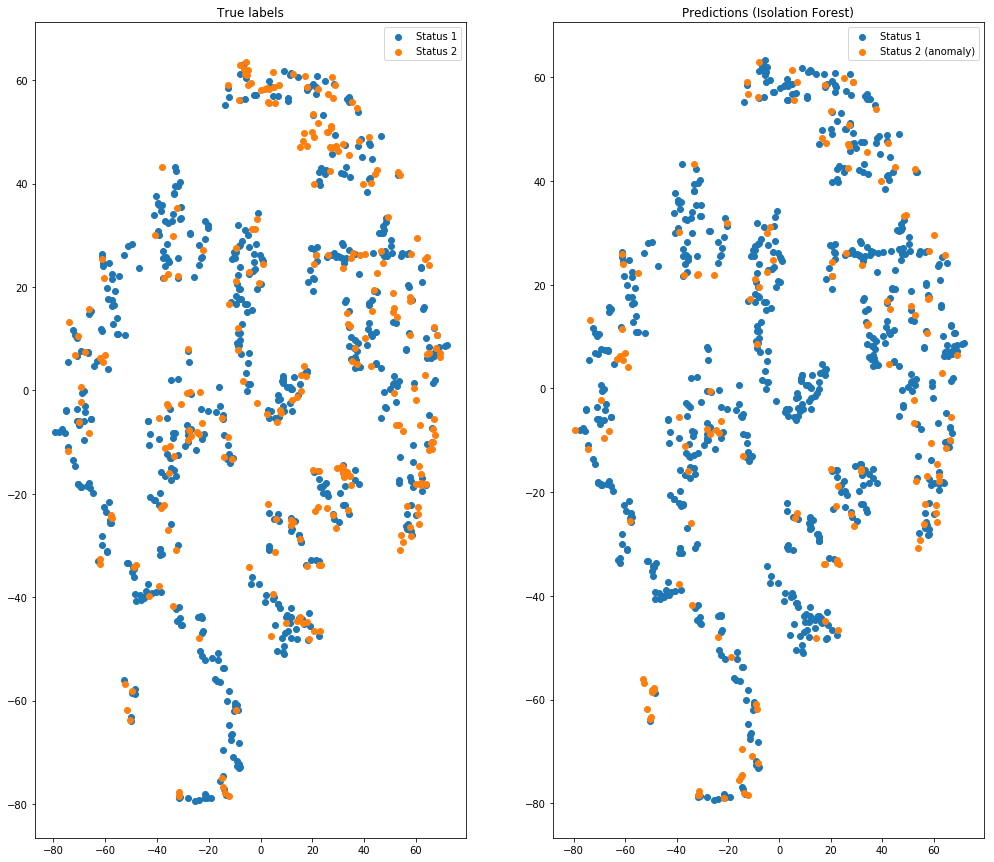

In [160]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Isolation Forest)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2 (anomaly)')
plt.legend()

### Резюме
**Плюсы:**
* Способен выявлять сложные закономерности
* Можно обучать на одних данных, а применять - к другим
* Быстрый и масштабируемый

**Минусы:**
* Склонен к переобучению

**Что можно улучшить:**
* Погридсёчить параметры

**Специфика применения:** - выбросы и новизна

## 3.3 EllipticEnvelope
Подход похож на One-class SVM, только "оборачивает" обучающую выборку выпуклой эллиптической оболочкой

In [141]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope()
clf.fit(X_train[y_train == 1]) # покажем нашей модели, как выглядят хорошие заёмщики
y_pred = clf.predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = 1 + (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 2, а +1 перешла в +1

accuracy_score(y_pred, y_test)

c:\users\artem\anaconda3\envs\wos\lib\site-packages\sklearn\covariance\robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


0.66329966329966328

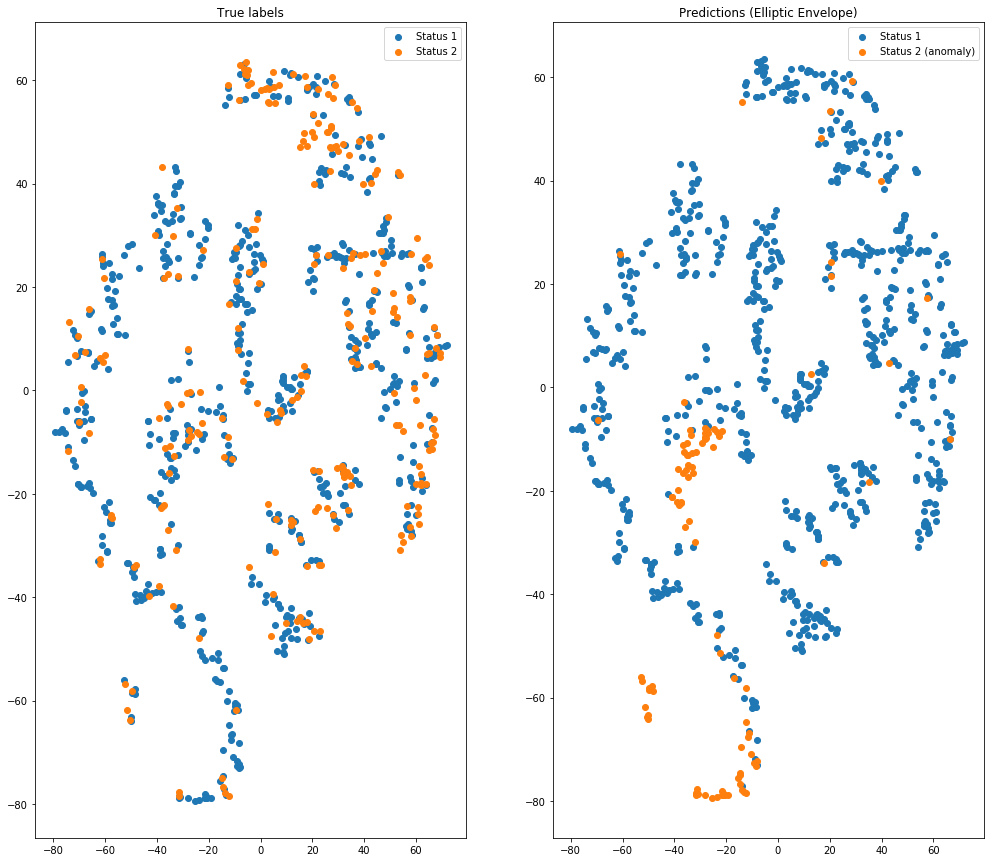

In [143]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Elliptic Envelope)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2 (anomaly)')
plt.legend()

### Резюме
**Плюсы:**
* Простой
* Быстрый

**Минусы:**
* Плохо работает на сложных данных

**Что можно улучшить:**
* Погридсёчить параметры

**Специфика применения:** только новизна и сильные выбросы

# Полезные ссылки
* [Поиск аномалий в данных](https://alexanderdyakonov.wordpress.com/2017/04/19/поиск-аномалий-anomaly-detection/)